# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

09:15:45 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=175178;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=667200;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=778513;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=951311;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

09:16:40 INFO      Auto-determined polynomial order: 0                                ]8;id=721755;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=476128;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

09:16:59 INFO      None 0-order polynomial fit with the mle method                               ]8;id=948434;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=518846;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=964829;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=393369;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=572501;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=318100;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:17:00 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=585369;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=565178;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=367155;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=697053;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=954603;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=980290;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=774044;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=115021;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=263304;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=302486;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=277899;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=346213;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

09:17:03 INFO      Now using 120 bins                                                          ]8;id=519370;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=956564;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

09:17:06 INFO      Auto-determined polynomial order: 1                                ]8;id=733592;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=373067;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

09:17:26 INFO      None 1-order polynomial fit with the mle method                               ]8;id=697641;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=711377;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=978478;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=495915;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=382084;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=920308;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=581478;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=984629;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=942126;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=72307;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

09:17:27 INFO      Auto-probed noise models:                                                    ]8;id=504129;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=984843;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=111349;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=972771;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=943733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=798337;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=179239;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=439185;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=176918;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=945174;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

09:17:29 INFO      Auto-determined polynomial order: 1                                ]8;id=879764;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=860215;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

09:17:49 INFO      None 1-order polynomial fit with the mle method                               ]8;id=213345;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=638679;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=388305;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=284642;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=809604;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=510401;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

09:17:50 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=482942;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=585805;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=243089;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=786435;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=246944;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=482161;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=312495;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=662220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=332957;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=313221;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=497890;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=580072;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=429144;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=783398;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

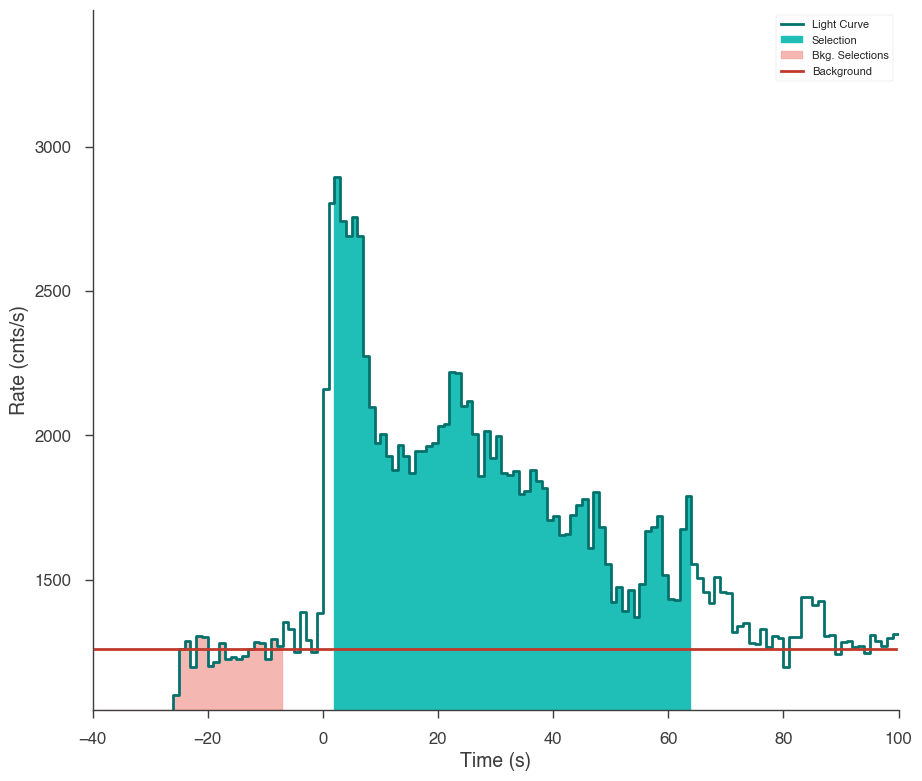

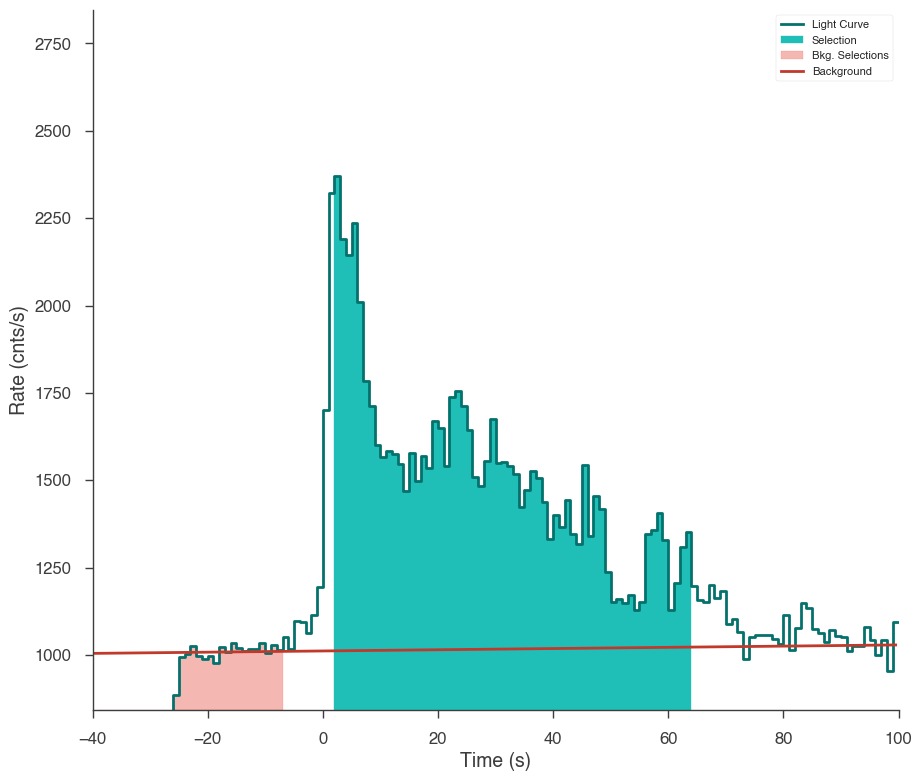

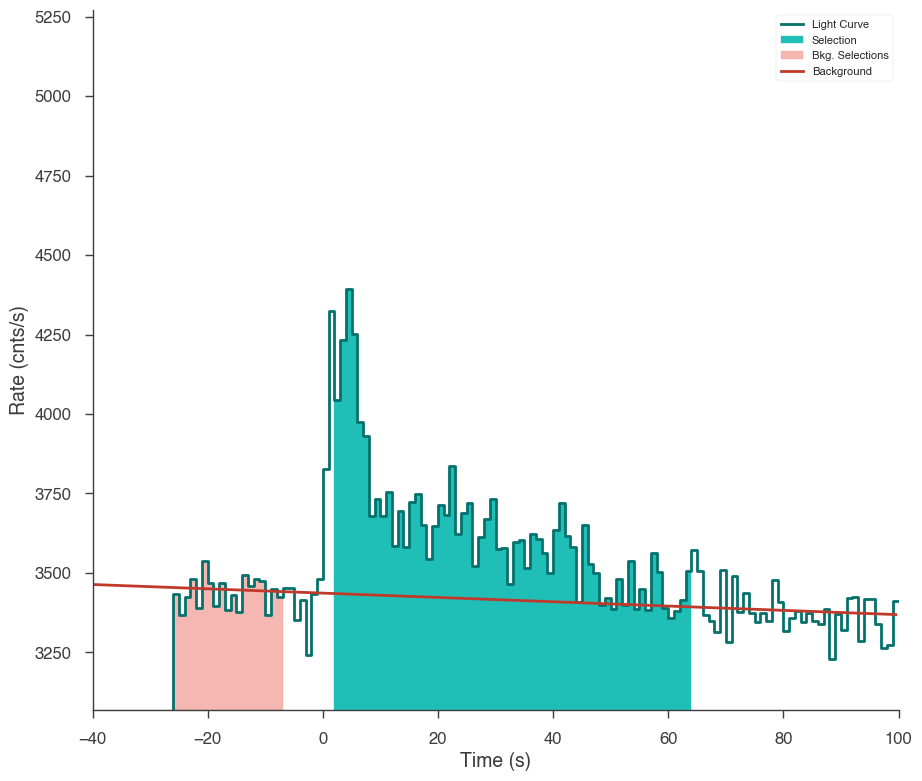

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

09:17:51 INFO      sampler set to multinest                                                ]8;id=466250;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=678237;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

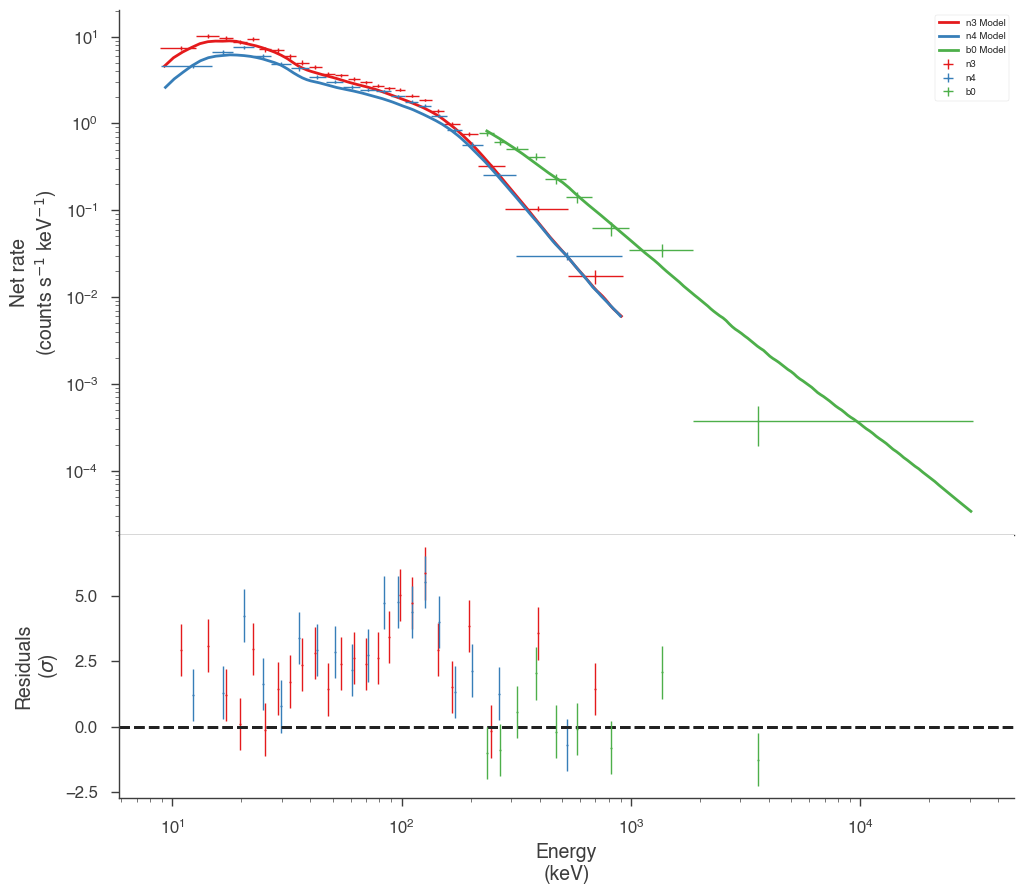

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3102.9199210412644      +/-  0.23387586614596900     
 Total Likelihood Evaluations:        22868
 Sampling finished. Exiting MultiNest



09:18:17 INFO      fit restored to maximum of posterior                                         ]8;id=258866;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=659336;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=176669;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=672992;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.479 -0.013 +0.018) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                  -1.077 -0.009 +0.023                 
GRB080916009...break_energy      (2.13 -0.19 +0.10) x 10^2              keV
GRB080916009...break_scale         (2.2 -0.6 +0.7) x 10^-1                 
GRB080916009...beta                      -2.05 -0.04 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1055.722788
n3        -1025.581318
n4        -1017.085874
total     -3098.389980

Values of statistical measures:

statistical measures
AIC              6206.950414
BIC              6226.182625
DIC              6178.449613
PDIC                3.638200
log(Z)          -1347.580999

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=68926;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=433660;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

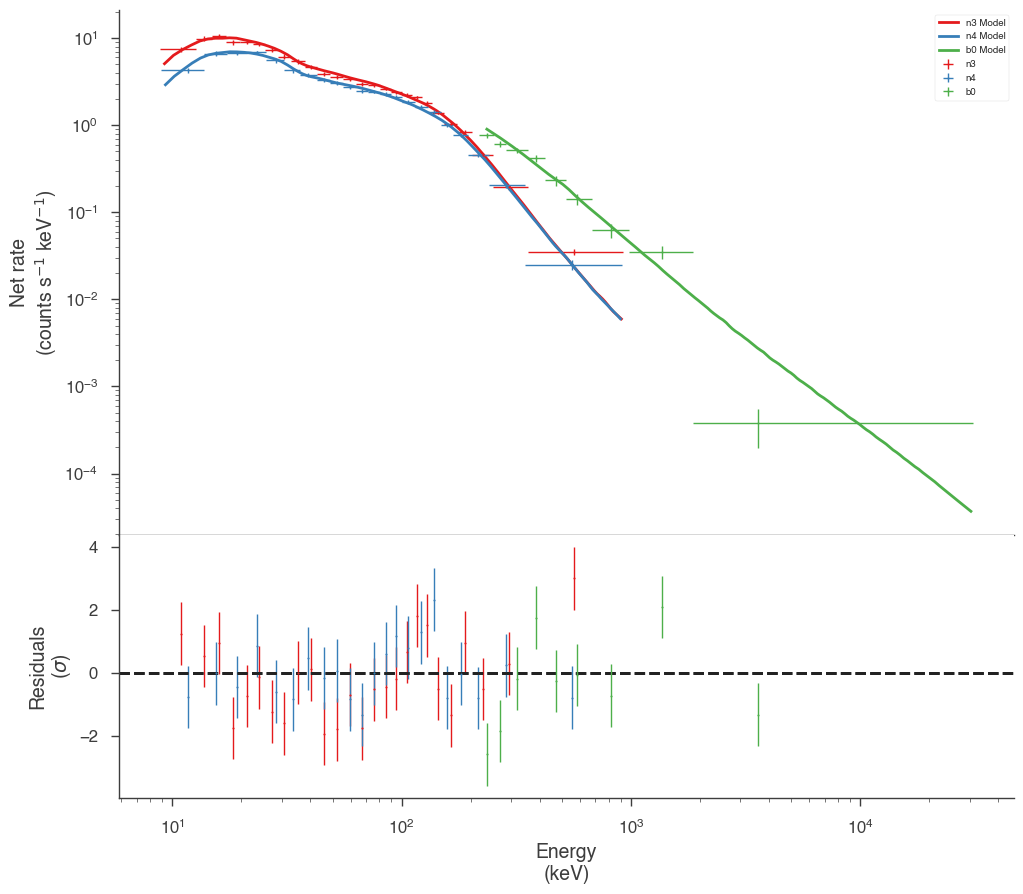

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

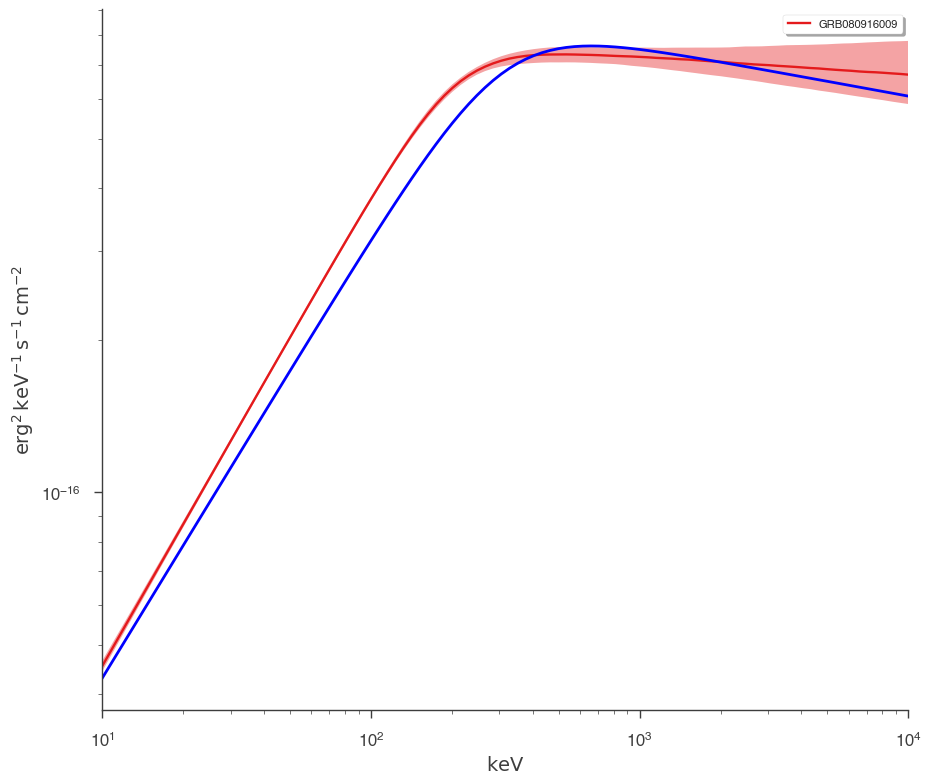

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

09:20:32 INFO      Created 15 bins via bayesblocks                                       ]8;id=278370;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=341634;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


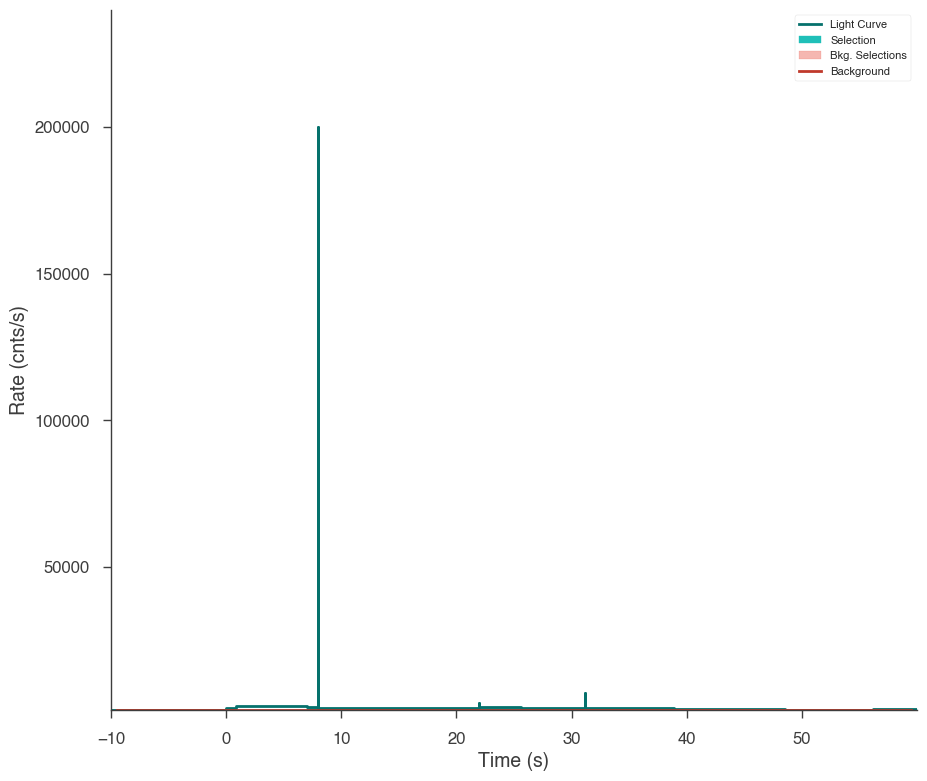

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=329681;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=634581;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

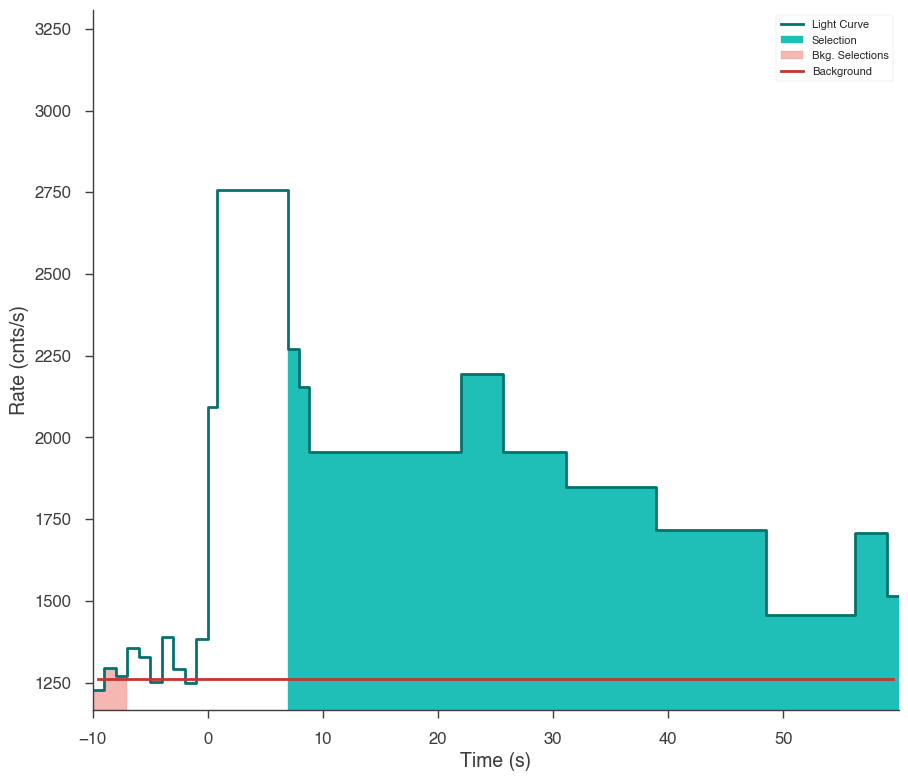

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

09:20:33 INFO      Created 12 bins via custom                                            ]8;id=909187;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=147037;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=148804;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=941511;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=27148;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=203108;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

09:20:34 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=827711;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=547054;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=616355;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=699814;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

09:20:35 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=527990;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=65997;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=436125;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=109604;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=393185;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=3577;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=706082;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=799792;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=99251;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=492571;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=22425;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=191738;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 107 bins                                                          ]8;id=136626;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=48839;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=892338;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=191775;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.87011741527976      +/-  0.18031869986690732     
 Total Likelihood Evaluations:        16518
 Sampling finished. Exiting MultiNest



09:20:53 INFO      fit restored to maximum of posterior                                         ]8;id=932573;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=671960;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=148864;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=819059;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (3.66 -0.7 +0.24) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-5.4 -1.6 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp      (3.06 -0.22 +1.1) x 10^2              keV
grb.spectrum.main.Band.beta            -2.05 -0.5 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.621304
n3_interval0      -250.091849
n4_interval0      -267.989356
total             -803.702509

Values of statistical measures:

statistical measures
AIC              1615.518333
BIC              1630.927151
DIC              1570.597217
PDIC                2.501433
log(Z)           -342.601939

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=896962;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=312641;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=144932;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=533587;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=104115;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=188500;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=569342;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=963009;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=988624;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=587735;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=174688;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=381772;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=990553;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=674387;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1949.4102313006908      +/-  0.22064847498108228     
 Total Likelihood Evaluations:        23083
 Sampling finished. Exiting MultiNest



09:21:19 INFO      fit restored to maximum of posterior                                         ]8;id=870323;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=905504;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=110194;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=907680;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                 
grb.spectrum.main.Band.K       (4.40 -0.04 +0.20) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.11 -0.10 +0.35) x 10^-1                 
grb.spectrum.main.Band.xp      (5.276 -0.5 +0.009) x 10^2              keV
grb.spectrum.main.Band.beta           -1.996 +0.006 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -676.552051
n3_interval1      -641.410785
n4_interval1      -643.950354
total            -1961.913190

Values of statistical measures:

statistical measures
AIC              3931.939694
BIC              3947.348511
DIC              3878.812055
PDIC                2.538560
log(Z)           -846.618106

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=638251;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=116566;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=209315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=305065;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=410723;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=49355;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=160220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=725261;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=21838;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=818972;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 115 bins                                                          ]8;id=685838;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=721055;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=35538;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=962083;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -906.54198414736925      +/-  0.19334500955043291     
 Total Likelihood Evaluations:        20554
 Sampling finished. Exiting MultiNest



09:21:42 INFO      fit restored to maximum of posterior                                         ]8;id=369691;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=58688;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=433755;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=11583;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.57 -0.20 +0.21) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha              -1.04 +/- 0.07                 
grb.spectrum.main.Band.xp         (5.6 -0.9 +2.6) x 10^2              keV
grb.spectrum.main.Band.beta           -1.875 -0.6 -0.010

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.326004
n3_interval2      -288.933405
n4_interval2      -312.178709
total             -925.438118

Values of statistical measures:

statistical measures
AIC              1858.989551
BIC              1874.398369
DIC              1805.163839
PDIC                2.040931
log(Z)           -393.706181

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=889420;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=880048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=100349;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=568328;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=551776;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=152727;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=547331;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=865038;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=544427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=216404;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 109 bins                                                          ]8;id=324760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=718034;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=378128;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=54415;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -792.21228536452134      +/-  0.17803861996451695     
 Total Likelihood Evaluations:        18081
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


09:22:03 INFO      fit restored to maximum of posterior                                         ]8;id=801287;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=145519;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=511213;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=816400;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                 
grb.spectrum.main.Band.K      (3.248 +0.006 +0.9) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-8.5 -0.4 +1.5) x 10^-1                 
grb.spectrum.main.Band.xp        (2.68 -0.7 -0.05) x 10^2              keV
grb.spectrum.main.Band.beta           -1.865 -0.022 +0.11

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.806488
n3_interval3      -241.737928
n4_interval3      -262.139146
total             -802.683561

Values of statistical measures:

statistical measures
AIC              1613.480437
BIC              1628.889255
DIC              1573.099576
PDIC                2.030283
log(Z)           -344.053424

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=368476;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=289189;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=734433;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=672951;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=185760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=556870;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=633077;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=187148;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=432889;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=813512;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=839235;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=31102;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=14903;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=661113;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -2271.7833300484390      +/-  0.20317567422134789     
 Total Likelihood Evaluations:        21495
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


09:22:25 INFO      fit restored to maximum of posterior                                         ]8;id=496902;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=127691;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=296356;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=422478;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.06 -0.05 +0.14) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.80 -0.24 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp       (3.90 -0.5 +0.21) x 10^2              keV
grb.spectrum.main.Band.beta          -1.947 -0.023 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.395372
n3_interval4      -757.038453
n4_interval4      -746.741857
total            -2282.175682

Values of statistical measures:

statistical measures
AIC              4572.464679
BIC              4587.873496
DIC              4526.524315
PDIC                2.712440
log(Z)           -986.622964

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=450392;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=636903;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=272511;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=611310;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=260753;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=29429;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=728226;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=949660;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=612800;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=794809;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=565771;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=836279;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=493898;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=430963;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1572.9424209645836      +/-  0.19060707952028025     
 Total Likelihood Evaluations:        20975
 Sampling finished. Exiting MultiNest



09:22:46 INFO      fit restored to maximum of posterior                                         ]8;id=386998;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=373332;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=363430;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=520575;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.83 -0.23 +0.15) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-9.0 -0.6 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp       (4.08 -0.32 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta            -2.14 -0.29 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.480077
n3_interval5      -523.773290
n4_interval5      -527.574124
total            -1587.827491

Values of statistical measures:

statistical measures
AIC              3183.768297
BIC              3199.177114
DIC              3136.844546
PDIC                3.381657
log(Z)           -683.120214

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=509755;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=317361;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=761580;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=794709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=922597;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=322340;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=204942;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=75985;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=131188;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=845938;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=723785;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=748403;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=479281;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=983530;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.1464137922778      +/-  0.19184022742143067     
 Total Likelihood Evaluations:        20850
 Sampling finished. Exiting MultiNest



09:23:07 INFO      fit restored to maximum of posterior                                         ]8;id=85896;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=315176;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=955981;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=364044;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.94 -0.10 +0.15) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.02 -0.04 +0.06                 
grb.spectrum.main.Band.xp           (4.6 +/- 0.7) x 10^2              keV
grb.spectrum.main.Band.beta             -2.37 -0.4 +0.18

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.654302
n3_interval6      -584.316077
n4_interval6      -576.962756
total            -1770.933135

Values of statistical measures:

statistical measures
AIC              3549.979585
BIC              3565.388403
DIC              3501.180649
PDIC                3.292153
log(Z)           -762.250402

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=545012;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=425293;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=381242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=974217;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=836434;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=223052;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=607780;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=829808;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=21322;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=430379;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=995769;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=599104;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=4247;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=881734;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.5871528507164      +/-  0.19270712593178524     
 Total Likelihood Evaluations:        19709
 Sampling finished. Exiting MultiNest



09:23:27 INFO      fit restored to maximum of posterior                                         ]8;id=805379;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=427949;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=827049;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=58013;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.67 -0.10 +0.11) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.04 -0.05 +0.04                 
grb.spectrum.main.Band.xp         (4.3 -0.5 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta            -2.21 -0.31 +0.10

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.306577
n3_interval7      -640.635415
n4_interval7      -650.482219
total            -1953.424212

Values of statistical measures:

statistical measures
AIC              3914.961738
BIC              3930.370555
DIC              3868.398485
PDIC                3.214226
log(Z)           -842.351998

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=455293;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=582236;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=994681;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=44813;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=467313;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=595096;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=712081;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=783843;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=512628;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=360722;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=794972;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=614520;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=755966;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=742272;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2054.7385649111739      +/-  0.19072397611092892     
 Total Likelihood Evaluations:        18656
 Sampling finished. Exiting MultiNest



09:23:46 INFO      fit restored to maximum of posterior                                         ]8;id=791647;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=495448;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=45128;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=335825;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.54 -0.09 +0.16) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.5 -0.5 +0.8) x 10^-1                 
grb.spectrum.main.Band.xp         (3.7 -0.5 +0.4) x 10^2              keV
grb.spectrum.main.Band.beta            -2.29 -0.26 +0.15

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -702.025464
n3_interval8      -698.422874
n4_interval8      -666.191469
total            -2066.639807

Values of statistical measures:

statistical measures
AIC              4141.392928
BIC              4156.801746
DIC              4097.294949
PDIC                2.913837
log(Z)           -892.361620

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=870252;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=619444;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=245482;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=280043;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=33307;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=143052;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=609706;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=166501;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=513324;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=527015;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=637343;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=476298;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=220492;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=293599;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.8737836423761      +/-  0.14638351140822711     
 Total Likelihood Evaluations:        13187
 Sampling finished. Exiting MultiNest



09:24:00 INFO      fit restored to maximum of posterior                                         ]8;id=819003;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=682620;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=736672;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=205565;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (1.03 -0.28 +1.7) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-8.9 -1.7 +4) x 10^-1                 
grb.spectrum.main.Band.xp        (1.2 -0.6 +0.4) x 10^2              keV
grb.spectrum.main.Band.beta           -1.90 -0.15 +0.19

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.443536
n3_interval9      -617.138027
n4_interval9      -616.373381
total            -1881.954944

Values of statistical measures:

statistical measures
AIC              3772.023202
BIC              3787.432020
DIC              3688.570028
PDIC              -58.181653
log(Z)           -815.984516

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=672196;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=231356;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=318719;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=799501;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=971459;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=242394;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=308872;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=451713;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=117954;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=714721;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=862668;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=557304;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=639347;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=486171;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1321.9207998760232      +/-  0.16577234219821813     
 Total Likelihood Evaluations:        15346
 Sampling finished. Exiting MultiNest



09:24:16 INFO      fit restored to maximum of posterior                                         ]8;id=697845;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=496157;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=656679;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=448447;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K         (2.1 +/- 0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.2 -1.7 +1.3) x 10^-1                 
grb.spectrum.main.Band.xp     (2.12 -0.33 +0.9) x 10^2              keV
grb.spectrum.main.Band.beta         -1.918 -0.6 +0.020

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.864687
n3_interval10      -437.609620
n4_interval10      -433.077891
total             -1331.552198

Values of statistical measures:

statistical measures
AIC              2671.217711
BIC              2686.626529
DIC              2634.932588
PDIC                0.749752
log(Z)           -574.102909

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=757835;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=487619;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=971609;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=292330;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=508043;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=127331;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=260766;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=273142;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=735126;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=435918;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=736634;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=51057;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=643273;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=222397;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -812.81978322056318      +/-  0.15388190173540145     
 Total Likelihood Evaluations:        14118
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


09:24:30 INFO      fit restored to maximum of posterior                                         ]8;id=667503;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=252913;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=570359;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=966127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K        (3.1 -0.9 +0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-4.3 -2.1 +0.9) x 10^-1                 
grb.spectrum.main.Band.xp     (1.27 -0.11 +0.31) x 10^2              keV
grb.spectrum.main.Band.beta            -2.14 -0.7 -0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.520932
n3_interval11      -272.755833
n4_interval11      -255.735934
total              -821.012699

Values of statistical measures:

statistical measures
AIC              1650.138713
BIC              1665.547530
DIC              1620.325790
PDIC                2.493874
log(Z)           -353.003147

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=469781;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=274219;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:31 INFO      fit restored to median of posterior                                          ]8;id=860602;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=488999;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=5379;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=881329;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:32 INFO      fit restored to median of posterior                                          ]8;id=952318;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=449946;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:33 INFO      fit restored to median of posterior                                          ]8;id=600726;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=915892;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:34 INFO      fit restored to median of posterior                                          ]8;id=567972;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=916544;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:35 INFO      fit restored to median of posterior                                          ]8;id=133003;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=370754;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:36 INFO      fit restored to median of posterior                                          ]8;id=733124;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=985680;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:37 INFO      fit restored to median of posterior                                          ]8;id=125728;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=522182;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:38 INFO      fit restored to median of posterior                                          ]8;id=599769;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=646360;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:39 INFO      fit restored to median of posterior                                          ]8;id=650759;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=934977;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

09:24:40 INFO      fit restored to median of posterior                                          ]8;id=190081;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=493373;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

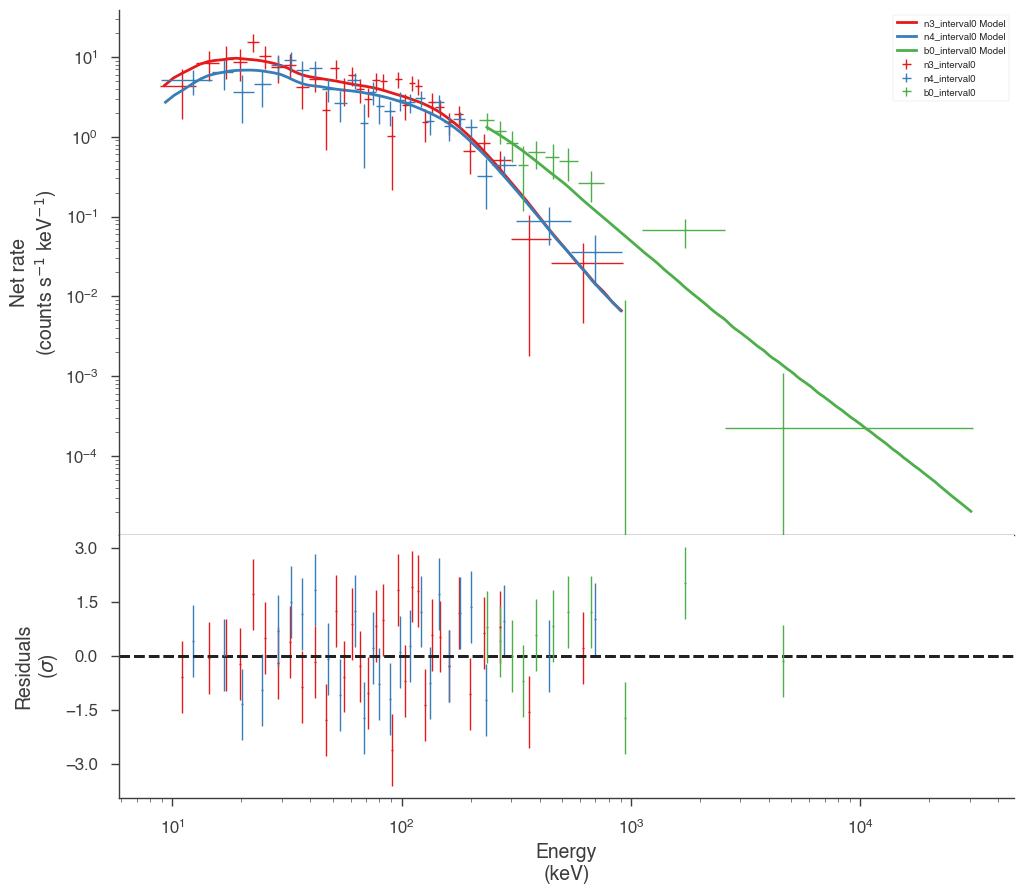

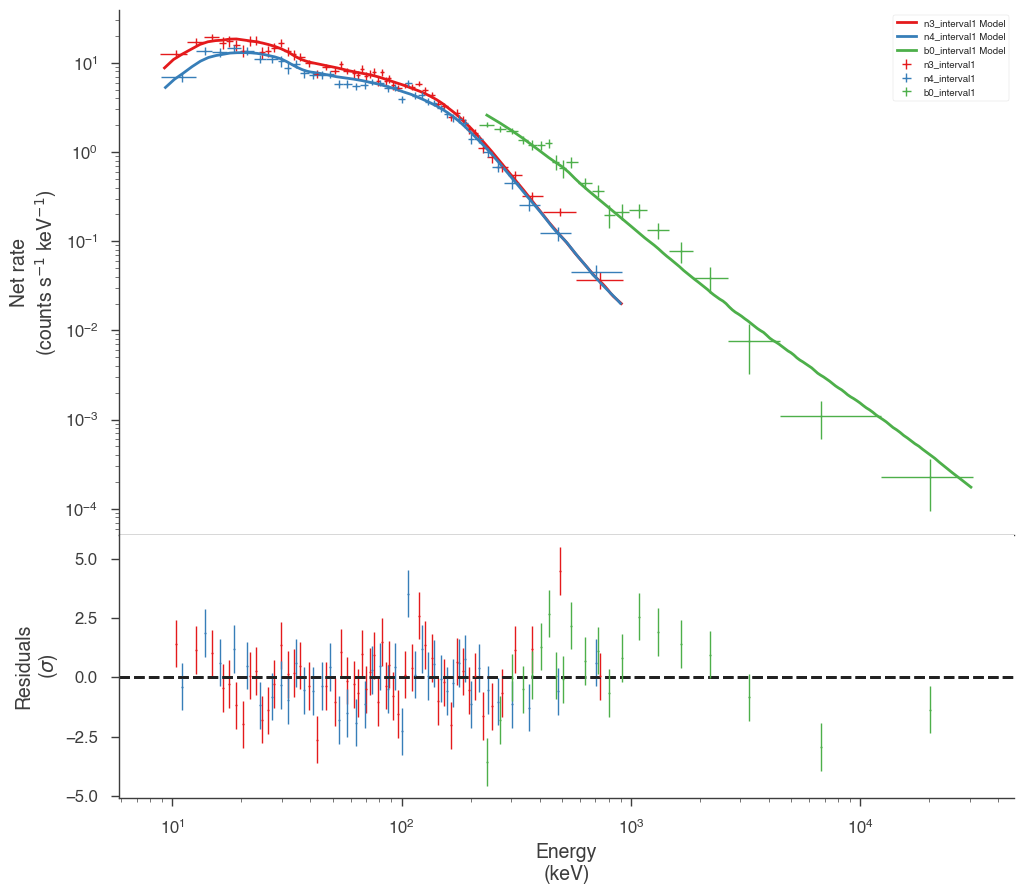

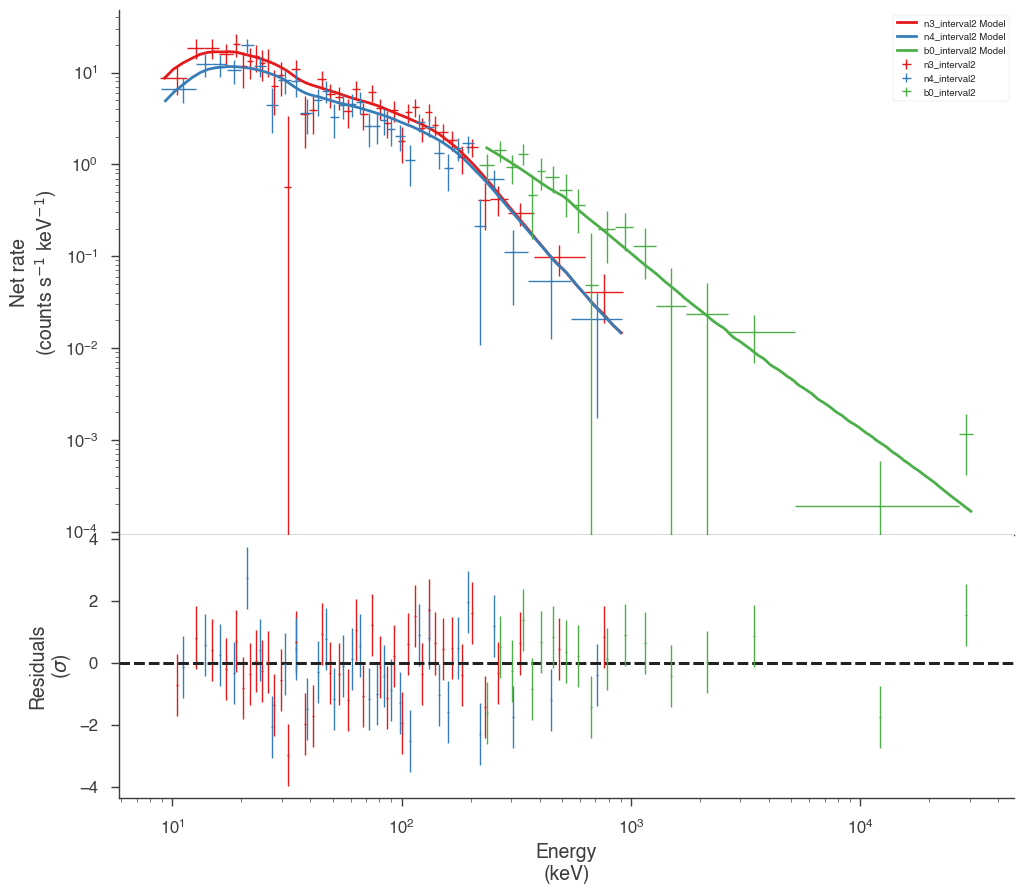

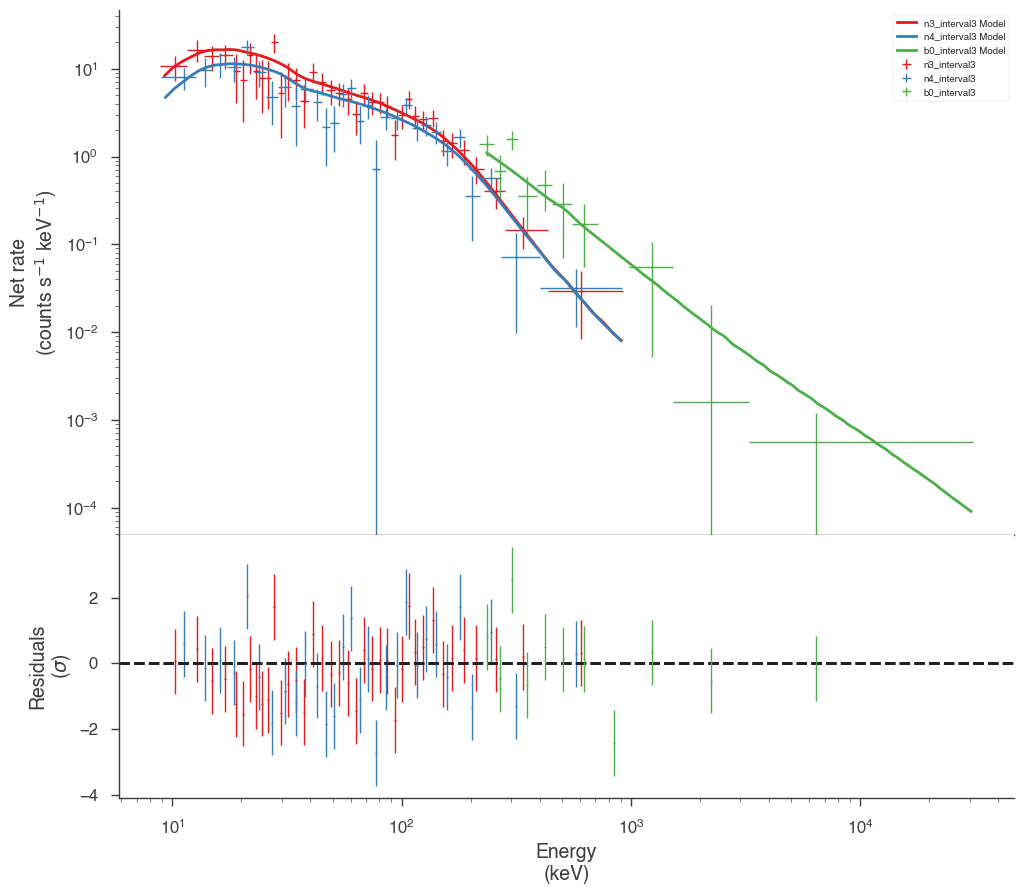

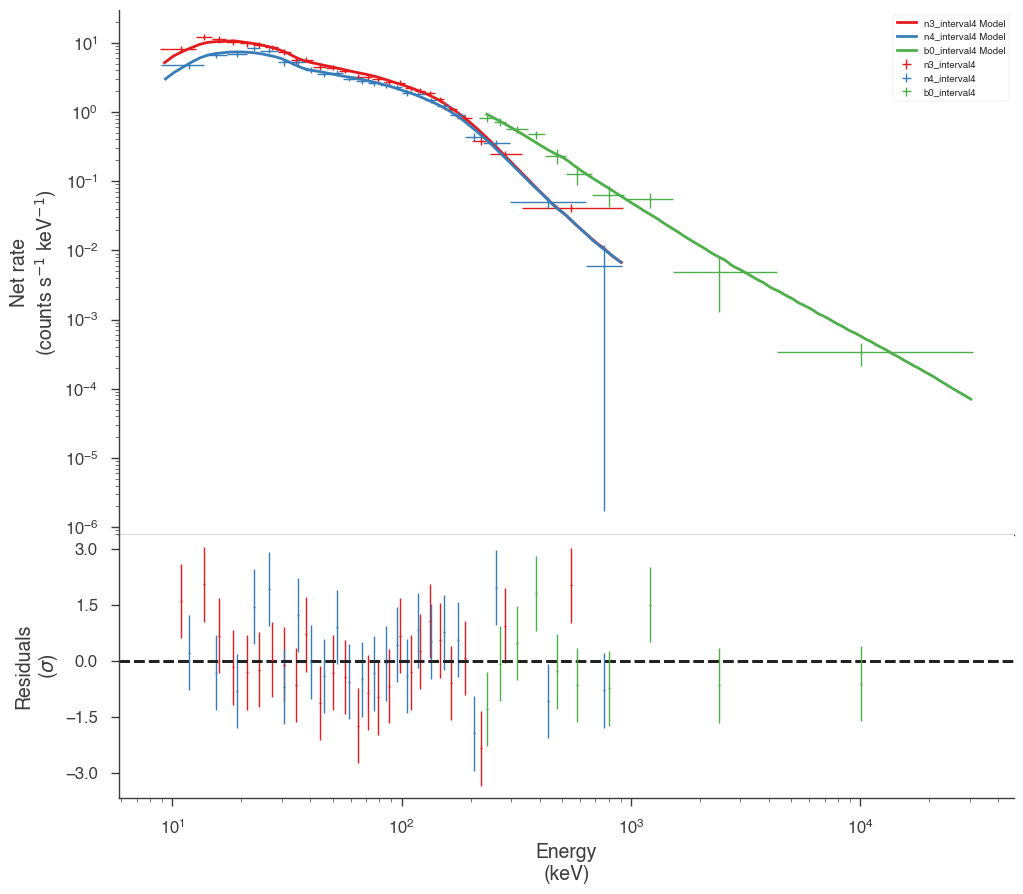

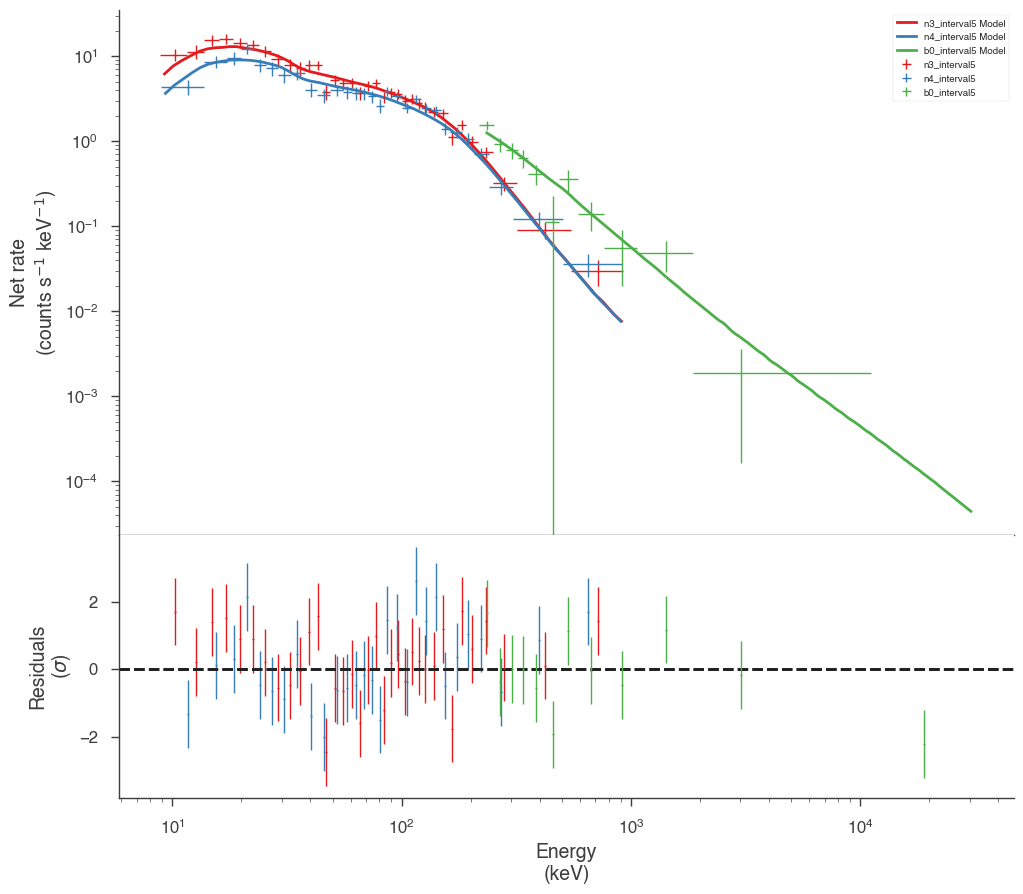

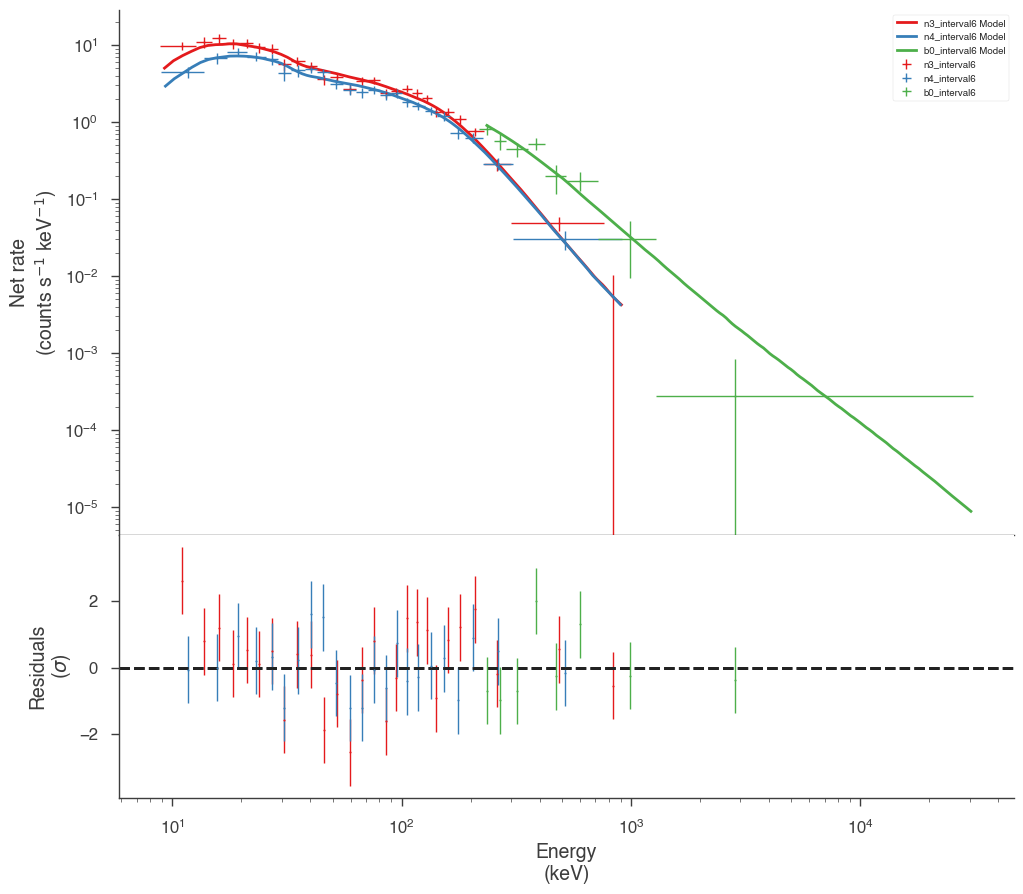

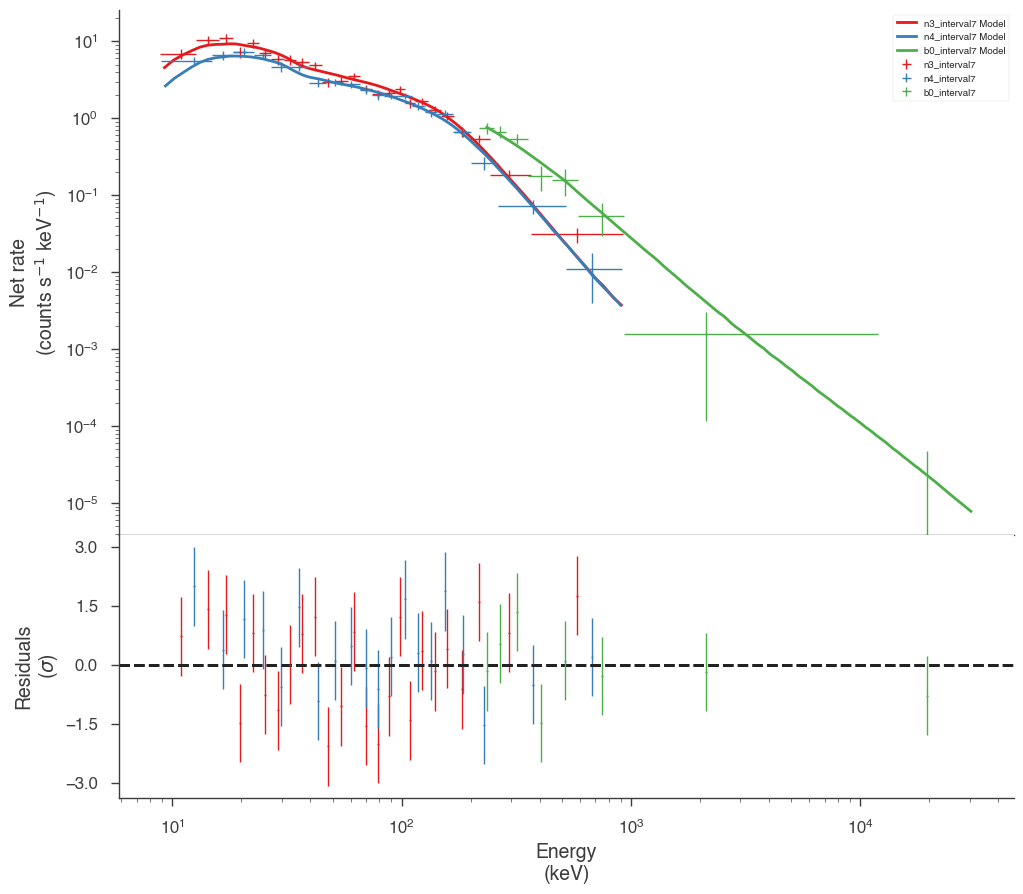

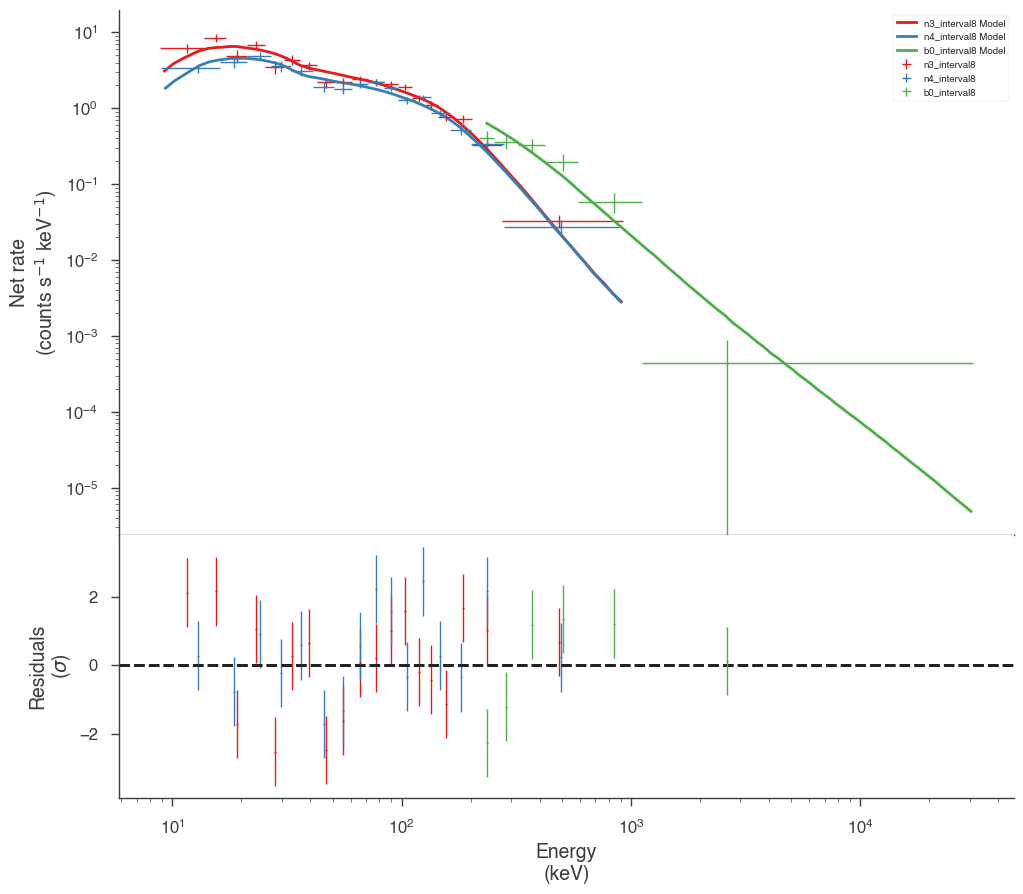

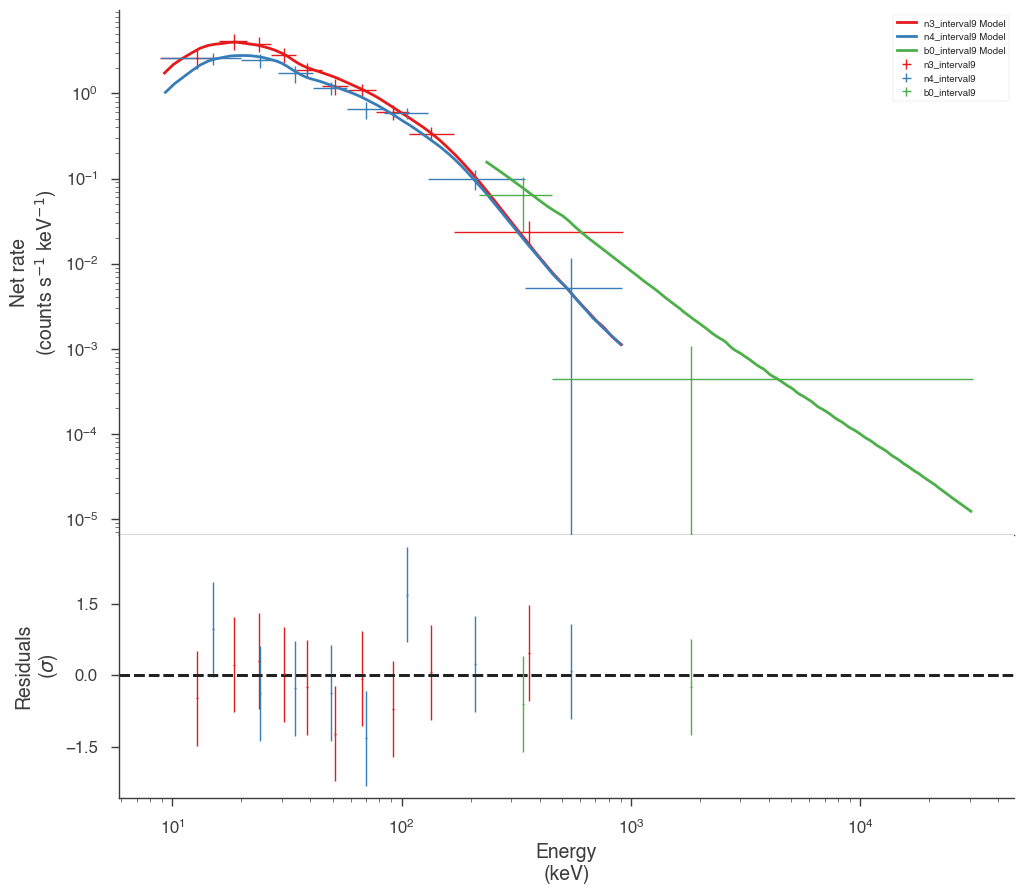

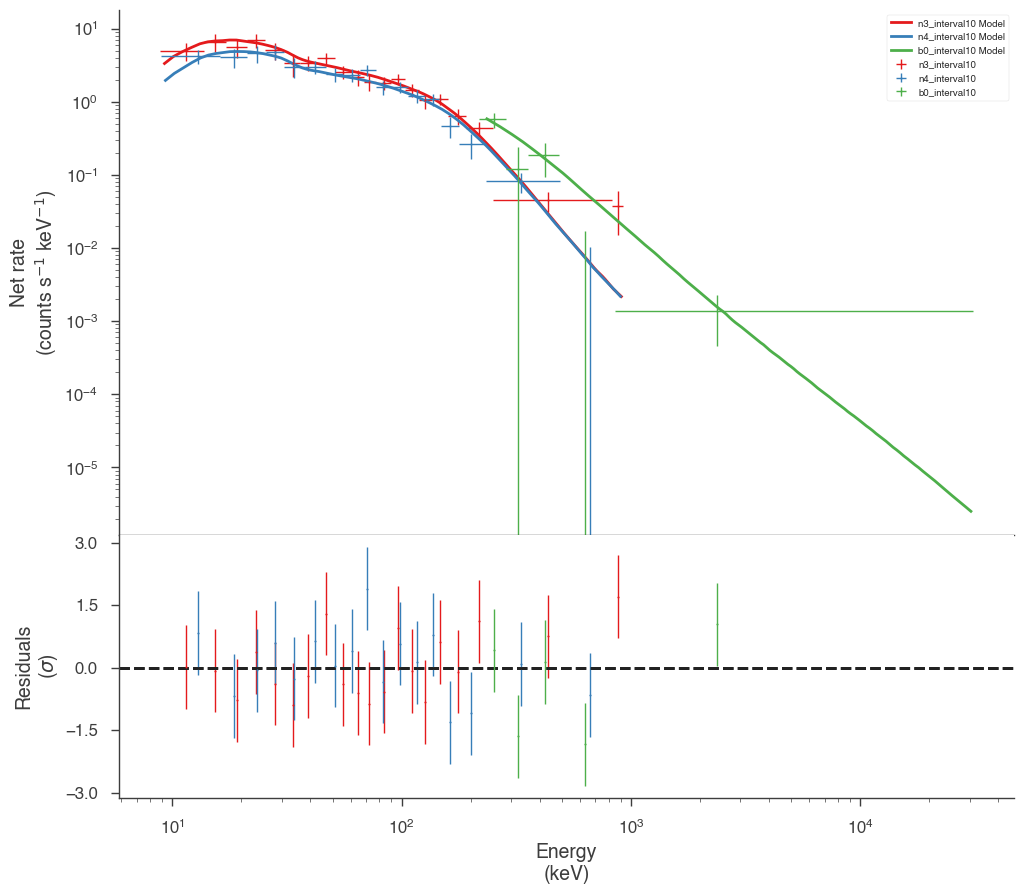

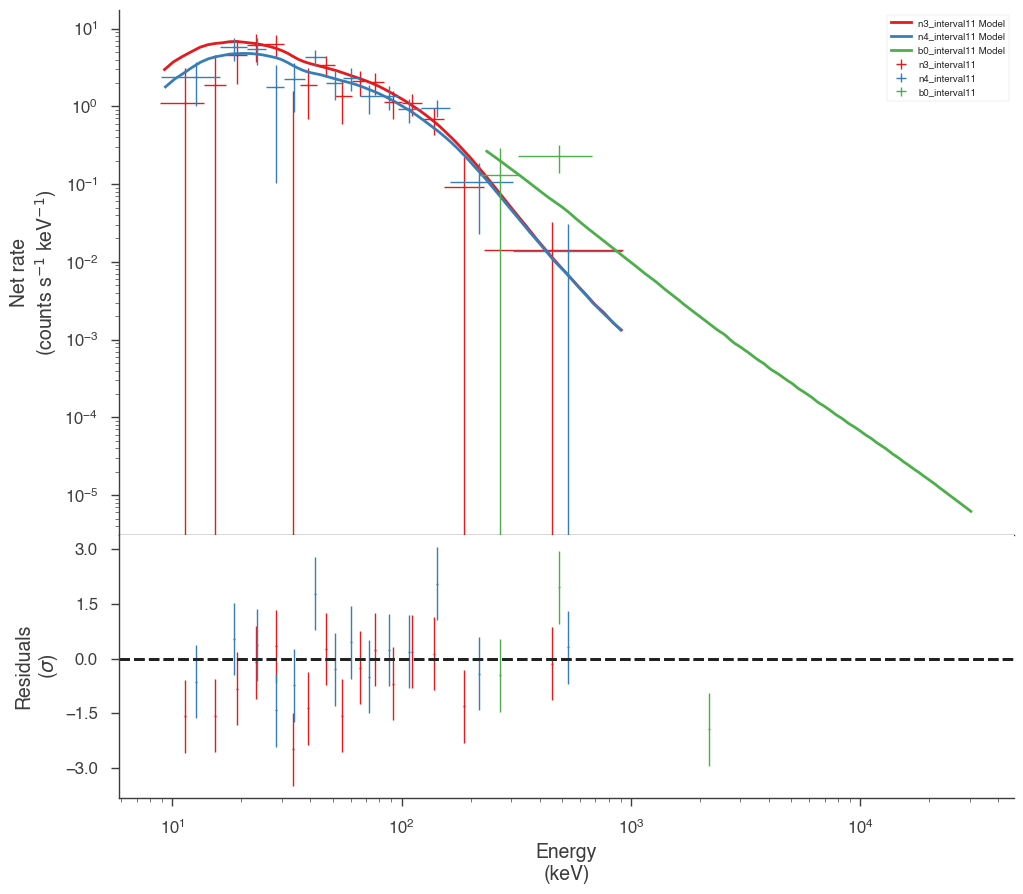

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

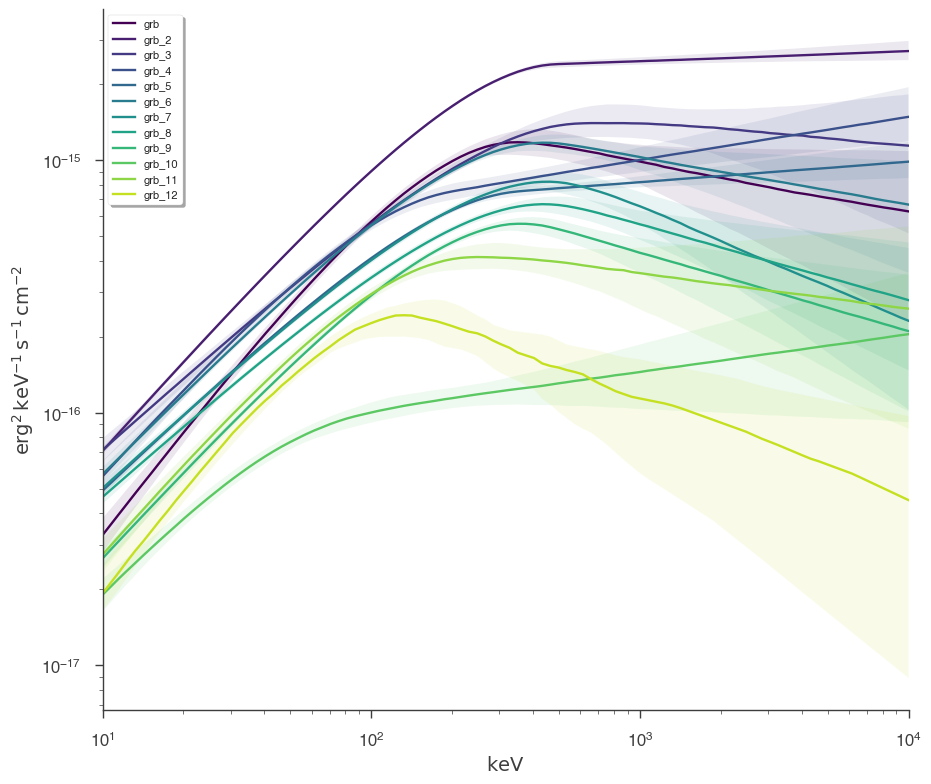

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.